#  Оптимизация маркетинговых затрат в Яндекс.Афише

Цель: ___помочь маркетологам оптимизировать маркетинговые затраты.___  

У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:  
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.  

Мы проанализируем:  
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.  

#### План работы:

[__Шаг 1. Загрузить данные и подготовить их к анализу__](#preparation).  

Загрузить данные о визитах, заказах и расходах в переменные. Оптимизировать данные для анализа. Убедиться, что тип данных в каждой колонке — правильный. Путь к файлам:  
- /datasets/visits_log.csv
- /datasets/orders_log.csv
- /datasets/costs.csv 

__Шаг 2. Построить отчёты и посчитайте метрики__  

- [Продукт](#product)
  - [Сколько людей пользуются в день, неделю, месяц?](#dau)
  - [Сколько сессий в день?](#session_amount_per_day)
  - [Сколько длится одна сессия?](#session_duration)
  - [Как часто люди возвращаются?](#retention)  
- [Продажи](#sales)
  - [Когда люди начинают покупать?](#purchase_period)
  - [Сколько раз покупают за период?](#orders_per_user)
  - [Какой средний чек?](#aov)
  - [Сколько денег приносят? (LTV)](#ltv)
- [Маркетинг](#marketing)
  - [Сколько денег потратили? Всего / на каждый источник / по времени](#costs_by_source)
  - [Сколько стоило привлечение одного покупателя из каждого источника?](#cac_by_source)
  - [На сколько окупились расходы? (ROI)](#romi)  
  
Отобразить на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?  
  
__Шаг 3. Написать вывод: порекомендовать маркетологам, куда и сколько им стоит вкладывать денег?__  

Какие источники/платформы? Объяснить свой выбор: на какие метрики мы ориентируемся? Почему? Какие выводы мы сделали, узнав значение метрик?
___
#### Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):  
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь  

Таблица orders (информация о заказах):  
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):  
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("hls", 8)
from IPython.display import display, HTML
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

<a name="preparation"></a>
## Подготовка данных

Загрузим данные о визитах, заказах и расходах в переменные.  
Оптимизируем данные для анализа.  
Убедимся, что тип данных в каждой колонке — правильный.

In [2]:
visits = pd.read_csv('../../datasets/visits_log.csv')
visits.name = 'Visits'
orders = pd.read_csv('../../datasets/orders_log.csv')
orders.name = 'Orders'
costs = pd.read_csv('../../datasets/costs.csv')
costs.name = 'Costs'
for df in [visits, orders, costs]:
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    print(color.UNDERLINE + color.CYAN + color.BOLD +'{}:'.format(df.name) + color.END)
    display(df.head())
    print('')
    print(color.UNDERLINE + color.BOLD + 'Info:' + color.END)
    print(df.info())
    print('')
    print(color.UNDERLINE + color.BOLD + 'Number of missing values:' + color.END)
    print(df.isna().sum())
    print('')
    print(color.UNDERLINE + color.BOLD + 'Number of duplicates:' + color.END, df.duplicated().sum())
    print('___________________________________________________________________')
    print('')

visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

Visits:


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     359400 non-null  object
 1   end_ts     359400 non-null  object
 2   source_id  359400 non-null  int64 
 3   start_ts   359400 non-null  object
 4   uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

Number of missing values:
device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

Number of duplicates: 0
___________________________________________________________________

Orders:


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

Number of missing values:
buy_ts     0
revenue    0
uid        0
dtype: int64

Number of duplicates: 0
___________________________________________________________________

Costs:


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None

Number of missing values:
source_id    0
dt           0
costs        0
dtype: int64

Number of duplicates: 0
___________________________________________________________________



##### Комментарий

Названия столбцов приведены к единому виду, столбцы с датами приведены к типу datetime. Пропуски и дубликаты не найдены.

## Отчёты и метрики

<a name='product'></a>
### Продукт

<a name='dau'></a>
_Посмотрим на активность пользователей в трёх измерениях:
DAU (от англ. daily active users) — количество уникальных пользователей в день;
WAU (от англ. weekly active users) — количество уникальных пользователей в неделю;
MAU (от англ. monthly active users) — количество уникальных пользователей в месяц.
Также выведем соотношение пользователей мобильных устройств и компьютеров:_

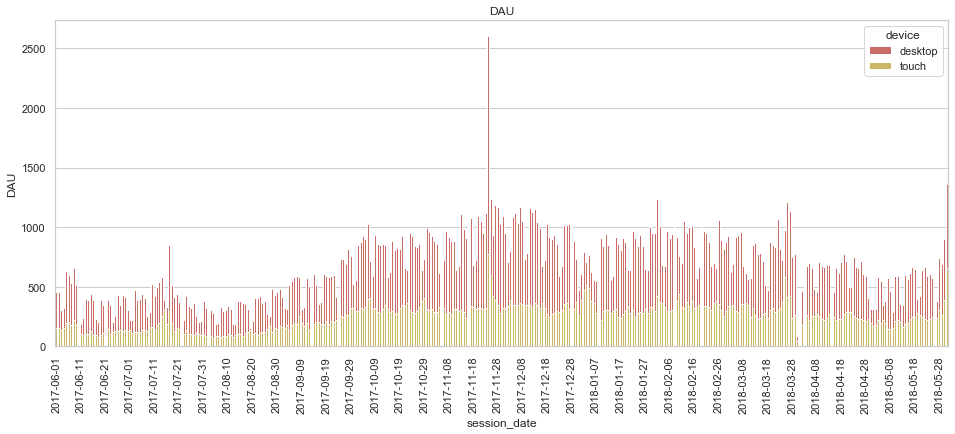

Desktop DAU-mean = 659 (72.3%)
Mobile DAU-mean = 252 (27.7%)


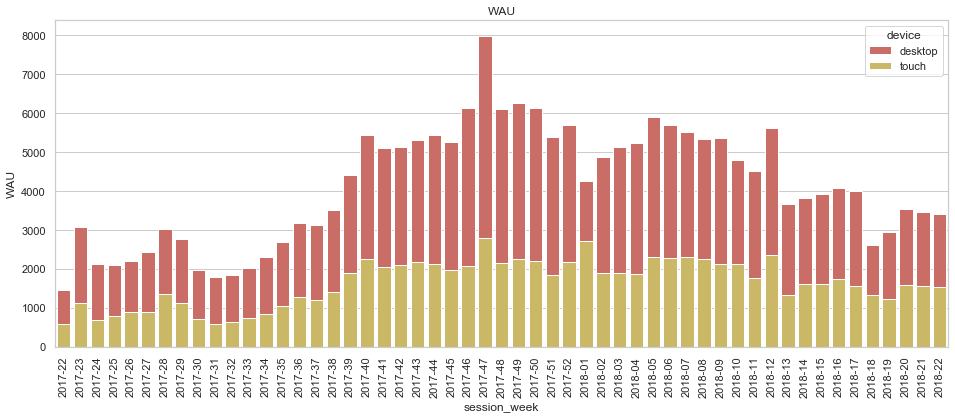

Desktop WAU-mean = 4129 (71.6%)
Mobile WAU-mean = 1634 (28.4%)


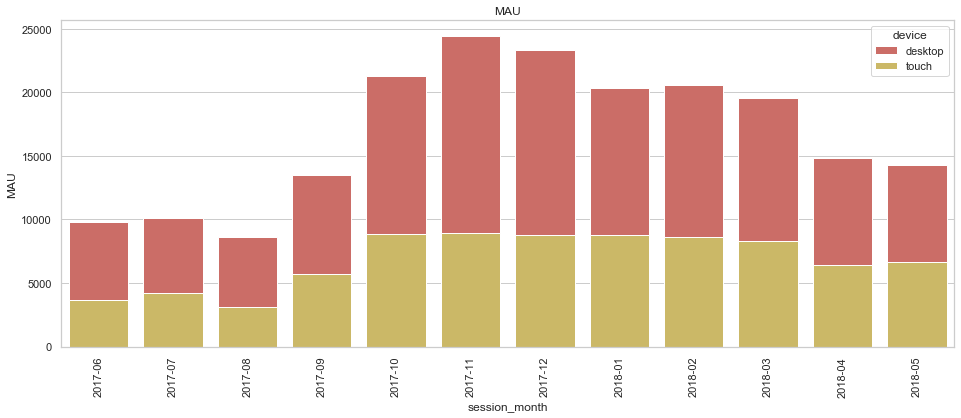

Desktop MAU-mean = 16724 (71.0%)
Mobile MAU-mean = 6825 (29.0%)


In [3]:
visits['session_month'] = visits['start_ts'].dt.strftime('%Y-%m')
visits['session_week']  = visits['start_ts'].dt.strftime('%Y-%W')
visits['session_date'] = visits['start_ts'].dt.strftime('%Y-%m-%d')

for i in [['session_date', 'DAU'], ['session_week', 'WAU'], ['session_month', 'MAU']]:
    nunique_visits_by_term = visits.pivot_table(index=[i[0], 'device'], 
                                                values='uid', 
                                                aggfunc='nunique')
    nunique_visits_by_term = nunique_visits_by_term.loc[:,['uid']].reset_index()

    plt.figure(figsize=(16, 6))
    ax = sns.barplot(x=i[0], y='uid', hue='device', data=nunique_visits_by_term, dodge=False)
    if i[0] == 'session_date':
        for ind, label in enumerate(ax.get_xticklabels()):
            if ind % 10 == 0:  # every 10th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    plt.title(i[1])
    plt.ylabel(i[1])
    plt.xlabel(i[0])
    plt.xticks(rotation=90)
    plt.show()
    
    au_desktop = int(nunique_visits_by_term.query('device == "desktop"')['uid'].mean())
    au_touch = int(nunique_visits_by_term.query('device == "touch"')['uid'].mean())
    print('Desktop {}-mean = {} ({:.1%})'.format(i[1], au_desktop, (au_desktop/(au_desktop + au_touch))))
    print('Mobile {}-mean = {} ({:.1%})'.format(i[1], au_touch, (au_touch/(au_desktop + au_touch))))

##### Комментарий:

Перед нами графики количества уникальных пользователей в день/ в неделю/ в месяц.  
Средние показатели за весь период исследования:
- DAU _(количество уникальных пользователей в день)_ : 907 (из них пользователи ПК 72,3% / пользователи мобильных устройств 27,7%)
- DAU _(количество уникальных пользователей в день)_ : 5716 (из них пользователи ПК 71,6% / пользователи мобильных устройств 28,4%)
- MAU _(количество уникальных пользователей в месяц)_ : 23228 (из них пользователи ПК 71% / пользователи мобильных устройств 29%)  

<a name='session_amount_per_day'></a>
_Посмотрим cколько всего сессий в день для мобильных устройств и ПК и сколько сессий у одного пользовотеля в день:_

In [4]:
session_amount_per_day = visits.groupby(['session_date', 'device']).agg({'uid': ['count', 'nunique']})
session_amount_per_day.columns = ['n_sessions', 'n_users']
session_amount_per_day['sessions_per_user'] = session_amount_per_day['n_sessions'] / session_amount_per_day['n_users']

print('Average number of desktop sessions per day =',
      int(session_amount_per_day.query('device == "desktop"')['n_sessions'].mean()))
print('Average number of mobile sessions per day =',
      int(session_amount_per_day.query('device == "touch"')['n_sessions'].mean()))
print('____________')
print('')
print('Average number of desktop sessions per day per user =',
      int(session_amount_per_day.query('device == "desktop"')['sessions_per_user'].mean()))
print('Average number of mobile sessions per day per user =',
      int(session_amount_per_day.query('device == "touch"')['sessions_per_user'].mean()))

Average number of desktop sessions per day = 721
Average number of mobile sessions per day = 266
____________

Average number of desktop sessions per day per user = 1
Average number of mobile sessions per day per user = 1


<a name='session_duration'></a>
А теперь посмотрим сколько обычно длится одна сессия.

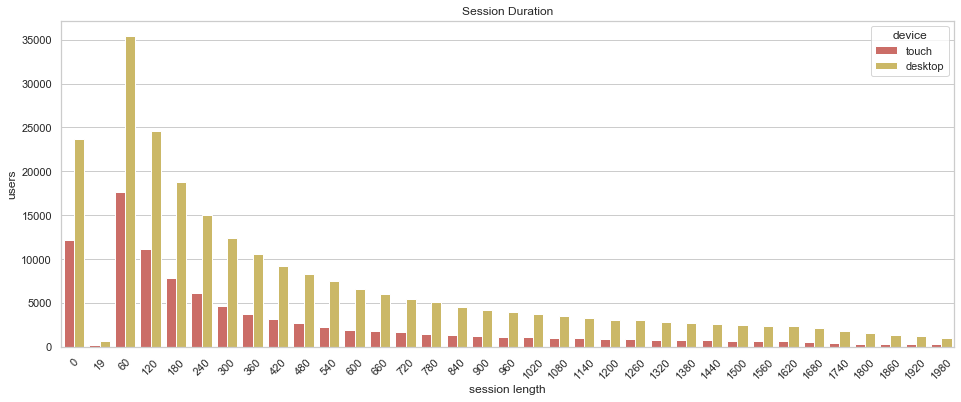

Desktop ASL(average session length) = 60 seconds
Mobile ASL(average session length) = 60 seconds


In [5]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
plt.figure(figsize=(16, 6))
ax=sns.countplot(x='session_duration', hue='device', data=visits[visits['session_duration'] <= 2000])
plt.ylabel('users')
plt.xlabel('session length')
plt.xticks(rotation=45)
plt.title('Session Duration')

plt.show()


print('Desktop ASL(average session length) = {} seconds'
      .format(visits.query('device == "desktop"')['session_duration'].mode()[0]))
print('Mobile ASL(average session length) = {} seconds'
      .format(visits.query('device == "touch"')['session_duration'].mode()[0]))

##### Комментарий:

Среднее количество сессий в день 987(из них 73% с десктопных и 27% с мобильных устройств), при этом обычно в день, один пользователь обращается к сервису только один раз.  
Чаще всего сессия длится 1 минуту.

<a name='retention'></a>
_Посмотрим как часто люди возвращаются, для этого сделаем когортный анализ по показателю Retention Rate:_  
___
_Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды._

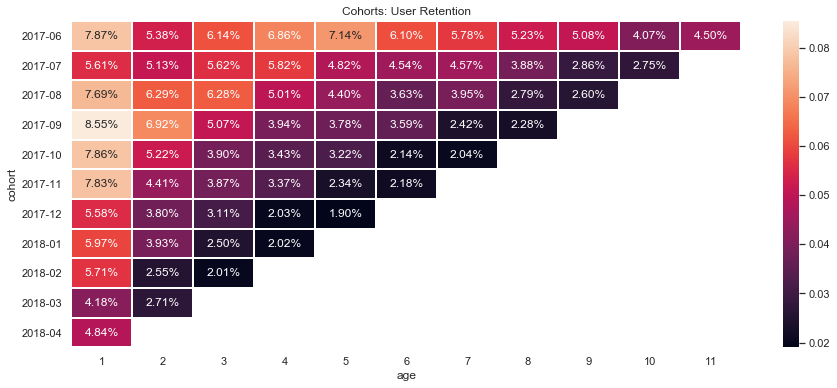

In [6]:
first_activity_date = visits.groupby('uid')['session_date'].min()
first_activity_date.name = 'first_activity_date'

user_activity = pd.merge(visits, first_activity_date, on='uid')
user_activity['activity_month'] = user_activity['session_date'].astype('datetime64[M]')
user_activity['first_activity_month'] = user_activity['first_activity_date'].astype('datetime64[M]')

user_activity['age'] = (((user_activity['activity_month'] - user_activity['first_activity_month'])
                        / np.timedelta64(1,'M'))
                        .round()
                        .astype('int'))

cohorts = (user_activity
           .groupby(['first_activity_month', 'age'])
           .agg({'uid': 'nunique'})
           .reset_index())

cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')
cohorts = cohorts.rename(columns={'first_activity_month': 'cohort'})

initial_users_count = cohorts[cohorts['age'] == 0][['cohort', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid': 'cohorts_users'})

cohorts = cohorts.merge(initial_users_count, on='cohort')
cohorts['retention'] = cohorts['uid'] / cohorts['cohorts_users']

retention_pivot = cohorts[cohorts['age'] > 0].pivot_table(index='cohort',
                                     columns='age',
                                     values='retention',
                                     aggfunc='sum')

plt.figure(figsize=(15,6))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot,
            annot=True, fmt='.2%', linewidths=1, linecolor='white')
plt.show()

_Построим barplot со средними показателями Retention Rate в течении жизненного цикла:_
___
Для удобства расчётов будем считать "жизненный цикл" равным полных 6 мес. + нулевой _(т.к. месяц, в который пользователь приходит, не полноценный - пользователь может прийти и 1-го и 31-го числа, будем считать его за нулевой)._

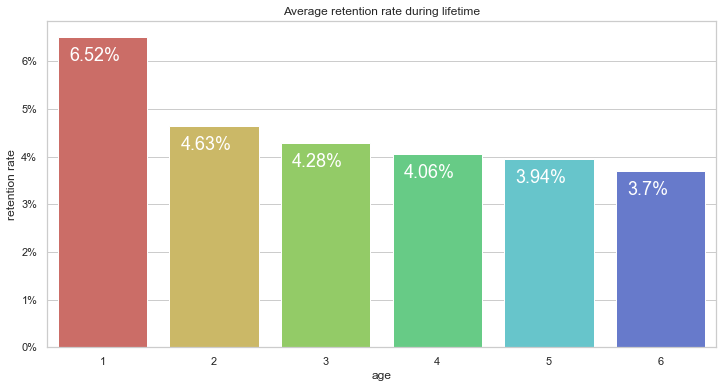

In [7]:
lifetime_retention_pivot = retention_pivot.loc[:,1:6]
plt.figure(figsize=(12, 6))
ax=sns.barplot(x=lifetime_retention_pivot.columns, y=lifetime_retention_pivot.mean())
ax.set_title('Average retention rate during lifetime')
ax.set_ylabel('retention rate')
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(x) for x in vals])
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()-0.005, 
            str(round(i.get_height() *100, 2))+'%', fontsize=18, color='white')
plt.show()

##### Комментарий:

Мы разделили всех приходящих пользователей на когорты, по месяцу прихода на сайт, чтобы посмотреть, как часто люди возвращаются.
На тепловой карте мы видим, что в первой когорте пользователи чаще возвращались на сайт. На графике видно, что в течении жизненного цикла с каждым месяцем процент возвращающихся пользователей падает (с 6,5% в первый месяц до 3,7% в шестой).   
_Т.к. нулевой месяц не показателен(во всех кагортах равен 100%) на данных графиках мы его не стали отображать._

#### Вывод:

Больше 70 процентов пользователей, заходят на сайт с компьютера, возможно это связано с тем, что пользоваться сервисов с мобильного устройства не очень удобно, необходимо протестировать UX мобильной версии сайта.  
  
Чаще всего сессия длится 1 минуту, что может говорить о том, что пользователь бежит, столкнувшись со сложным интерфейсом сервиса, может быть стоит показывать какой-то туториал для новых пользователей на главной странице.

С каждой новой когортой Retention Rate падает, нужно проследить какие изменения в сервисе приводят к такому результату.

<a name='sales'></a>
### Продажи

<a name='purchase_period'></a>
_Посмотрим когда люди начинают покупать, для этого посмотрим на разницу между первым визитом и первой покупкой, сравним средние результаты для мобильных устройств и ПК для каждой из когорт:_

Desktop users average period from first visit to purchase = 4.1 hours
Mobile users average period from first visit to purchase = 6.3 hours


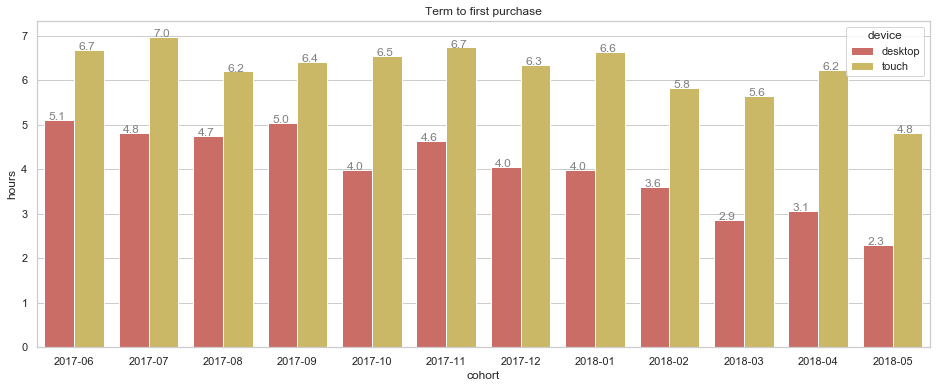

In [8]:
first_buy = orders.groupby('uid')['buy_ts'].min().reset_index()
first_buy = first_buy.rename(columns={'buy_ts':'first_buy_ts'})
first_session = visits.groupby(['uid', 'device'])['start_ts'].min().reset_index()
first_session = first_session.rename(columns={'start_ts':'first_start_ts'})

purchase_period = first_buy.merge(first_session, on='uid')
purchase_period['purchase_period'] = (purchase_period['first_buy_ts'] - purchase_period['first_start_ts']).dt.seconds
purchase_period['cohort'] =  purchase_period['first_start_ts'].astype('datetime64[M]').dt.strftime('%Y-%m')

purchase_pivot = (purchase_period.pivot_table(index=['cohort', 'device'], 
                                              values='purchase_period', 
                                              aggfunc='mean')
                  .reset_index())
print('Desktop users average period from first visit to purchase = {} hours'
      .format(round(purchase_period.query('device == "desktop"')['purchase_period'].mean()/ 3600, 1)))
print('Mobile users average period from first visit to purchase = {} hours'
      .format(round(purchase_period.query('device == "touch"')['purchase_period'].mean()/ 3600, 1)))
purchase_pivot['purchase_period'] = purchase_pivot['purchase_period'] / 3600

plt.figure(figsize=(16, 6))

ax=sns.barplot(x='cohort', y='purchase_period', hue='device', data=purchase_pivot)
plt.ylabel('hours')
plt.xlabel('cohort')
plt.title('Term to first purchase')
for i in ax.patches:
    ax.text(i.get_x()+.06, i.get_height(), 
            str(round(i.get_height(), 1)), fontsize=12, color='grey')
plt.show()


##### Комментарий:

В среднем для тех, кто  начал пользоваться сервисом с мобильного устройства, от первого визита до покупки проходит на 2 часа больше, чем для тех кто им пользовался с компьютера (4 часа против 6 часов 20 минут), к тому же с каждой новой когортой для пользователей ПК этот показатель в основном падает, чего нельзя сказать о пользователях мобильных устройств.  
Стоит поработать над мобильной версией.

<a name='orders_per_user'></a>
_Посмотрим сколько покупок в среднем делает пользователь:_

Usual number of purchases is 1


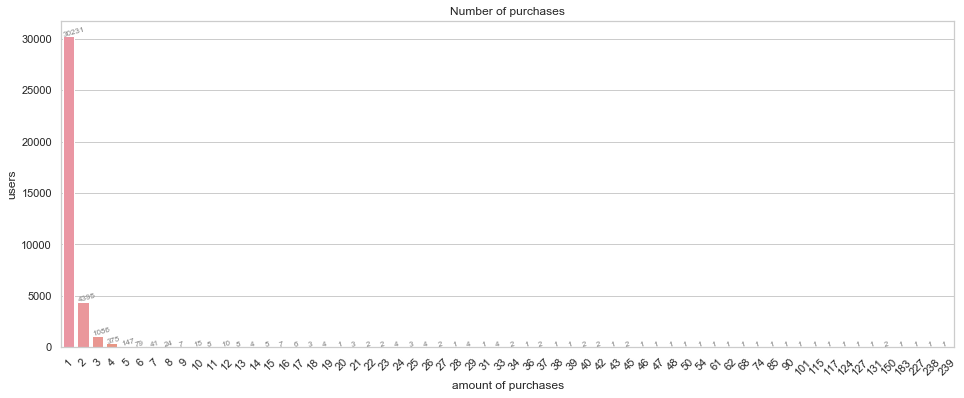

In [9]:
orders_per_user = orders.groupby('uid').agg({'revenue': ['count', 'sum']})
orders_per_user.columns = ['n_purchases', 't_purchases']
print('Usual number of purchases is', orders_per_user['n_purchases'].mode()[0])
plt.figure(figsize=(16, 6))
ax=sns.countplot(x='n_purchases', data=orders_per_user)
plt.ylabel('users')
plt.xlabel('amount of purchases')
plt.xticks(rotation=45)
plt.title('Number of purchases')
for i in ax.patches:
    ax.text(i.get_x(), i.get_height(), 
            str(int((i.get_height()))), fontsize=8, color='grey',rotation=15)
plt.show()


##### Комментарий:

Обычно пользователи делают не больше одной покупки, но есть и те, кто делает больше 200(хоть их и очень мало).

<a name='aov'></a>
_Посчитаем средний чек каждого пользователя для каждой когорты по месяцам. А также средний чек за весь период:_

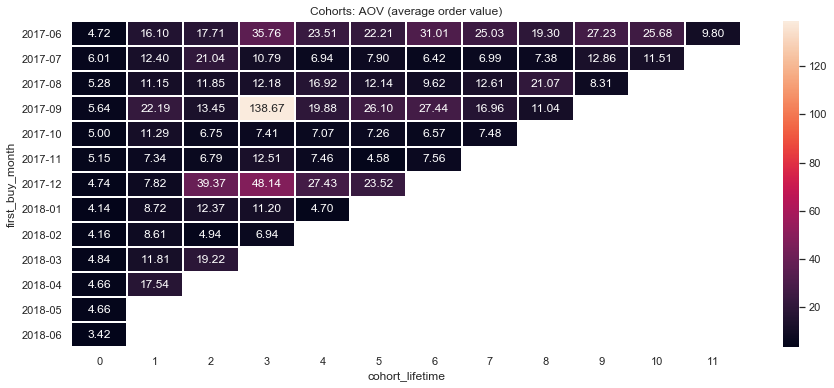

AOV (average order value) = 5.0


In [10]:
first_buy_ts = orders.groupby('uid')['buy_ts'].min()
first_buy_ts.name = 'first_buy_ts'
orders = orders.join(first_buy_ts,on='uid')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_buy_month'] = orders['first_buy_ts'].astype('datetime64[M]')
orders_by_cohorts = (orders
                     .groupby(['first_buy_month', 'buy_month'])
                     .agg({'revenue': 'sum', 'uid': 'nunique'})
                     .reset_index())
orders_by_cohorts['revenue_per_user'] = orders_by_cohorts['revenue'] / orders_by_cohorts['uid']
orders_by_cohorts.pivot_table(index='first_buy_month',
                             columns='buy_month',
                             values='revenue_per_user',
                             aggfunc='mean')
orders_by_cohorts['cohort_lifetime'] = (((orders_by_cohorts['buy_month'] - orders_by_cohorts['first_buy_month'])
                                        / np.timedelta64(1,'M'))
                                        .round()
                                        .astype('int'))
orders_by_cohorts['first_buy_month'] = orders_by_cohorts['first_buy_month'].dt.strftime('%Y-%m')
orders_by_cohorts_pivot = orders_by_cohorts.pivot_table(index='first_buy_month',
                             columns='cohort_lifetime',
                             values='revenue_per_user',
                             aggfunc='mean')
plt.figure(figsize=(15,6))
plt.title('Cohorts: AOV (average order value)')
sns.heatmap(orders_by_cohorts_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white')
plt.show()
print('AOV (average order value) = {:.1f}'.format(orders['revenue'].mean()))

##### Комментарий:

Глядя на тепловую карту мы видим, что в большинстве когорт средний чек со временем растёт. Также стоит отметить аномальные значения в третий месяц сентябрьской когорты(средний чек в этот месяц составил 138,7 у.е.), помимо этой когорты высокий средний чек был в первой когорте и в декабрьской.  
Средний же чек среди всех покупок равен 5 у.е.

<a name='ltv'></a>
_Сделаем когортный анализ по показателю LTV, для того чтобы понять, сколько денег приносят клиенты:_  
___
LTV (от англ. lifetime value) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок

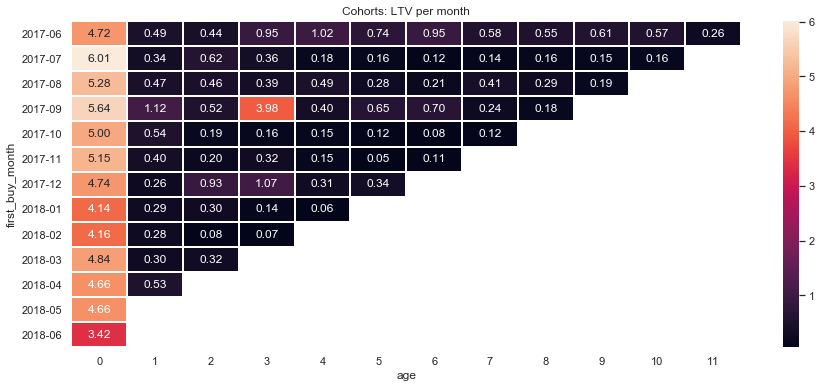

In [11]:
costs['month'] = costs['dt'].astype('datetime64[M]')

first_orders = orders.groupby('uid').agg({'buy_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_buy_month']

cohort_sizes = first_orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']

cohorts = orders.groupby(['first_buy_month', 'buy_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_buy_month')
report['age'] = (((report['buy_month'] - report['first_buy_month']) / np.timedelta64(1, 'M'))
                 .round()
                 .astype('int'))
report['ltv'] = report['revenue'] / report['n_buyers']
report['first_buy_month'] = report['first_buy_month'].dt.strftime('%Y-%m')
report_pivot = report.pivot_table(index='first_buy_month',
                                 columns='age',
                                 values='ltv',
                                 aggfunc='mean')

plt.figure(figsize=(15,6))
plt.title('Cohorts: LTV per month')
sns.heatmap(report_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white')
plt.show()

_Посчитаем средний LTV за "жизненный цикл".  
Для удобства расчётов будем считать "жизненный цикл" равным 6 полных месяцев + нулевой месяц(месяц первой покупки пользователя):_

In [12]:
print('Average LTV(if the lifetime is 6 month) = {:.2f}'.format(report_pivot.cumsum(1)[6].mean()))

Average LTV(if the lifetime is 6 month) = 8.39


<a name='ltv_source'></a>
_Теперь посчитаем среднюю пожизненную ценность клиента(LTV) в зависимости от рекламного источника, по которому он пришёл:_

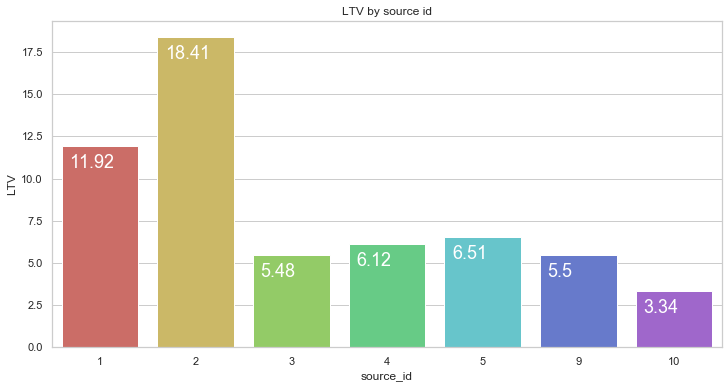

In [13]:
source = visits.loc[:, ['uid', 'source_id']].groupby('uid').agg({'source_id': 'first'})
orders = pd.merge(orders, source, on='uid', how='left')
orders['age'] = (((orders['buy_month'] - orders['first_buy_month']) / np.timedelta64(1, 'M'))
                 .round()
                 .astype('int'))

orders_six_month = orders[(orders['age'] <= 6) & (orders['first_buy_ts'] <= '2017-11-30')]

ltv_by_source = orders_six_month.groupby('source_id').agg({'revenue': 'sum', 'uid': 'nunique'})
ltv_by_source.columns = ['revenue', 'n_buyers']
ltv_by_source['ltv'] = ltv_by_source['revenue'] / ltv_by_source['n_buyers']
ltv_by_source.drop([7], inplace=True)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=ltv_by_source.index, y=ltv_by_source.ltv)
ax.set_ylabel('LTV')
ax.set_title('LTV by source id')
for i in ax.patches:
    ax.text(i.get_x()+i.get_width()/10, i.get_height()-1.3, 
            str(round(i.get_height(), 2)), fontsize=18, color='white')
plt.show()

#### Вывод:

Перед нами тепловая карта когорт, где средняя для когорты LTV(пожизненная ценность клиента) разбита по месяцам, из этой карты видно, что наиболее продуктивный месяц сточки зрения LTV, первый.  

__Средняя LTV(пожизненная ценность клиента) = 8,39__ у.е.  

Так же перед нами график величины LTV в зависимости от рекламного источника, по которому пришли пользователи. На нём видно, что лучшие показатели LTV у пользователей с источников под номером 1 и 2 (11,9 и 18,4 у.е. соответственно), а худшие у источников под номерами 3, 9, 10 (5,5, 5,5 и 3,3 у.е. соответственно). _Также тут необходимо отметить, что в данную метрику не попали рекламные источники под номерами 6, 7 и 8, ввиду отсутствия достаточного количества данных для оценки (данные по источнику под номером 7 были удалены из таблицы, т.к. из проживших полный цикл, пришедших с этого источника всего один пользователь, этого недостаточно для анализа данного показателя)_

<a name='marketing'></a>
### Маркетинг

<a name='costs_by_source'></a>
_Построим тепловую карту расходов по месяцам в зависимости от рекламного ресурса:_

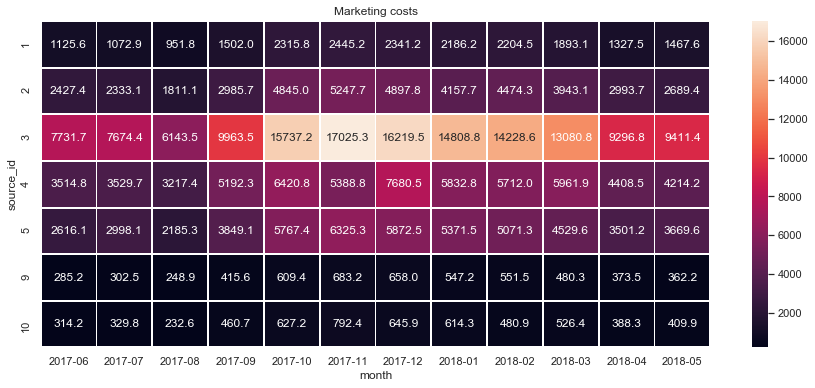

In [14]:
costs['month'] = pd.to_datetime(costs['month']).dt.strftime('%Y-%m')

costs_pivot = costs.pivot_table(index='source_id',
                 columns='month',
                 values='costs',
                 aggfunc='sum')
plt.figure(figsize=(15,6))
plt.title('Marketing costs')
sns.heatmap(costs_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='white')
plt.show()

_Построим график распределения расходов в зависимости от рекламного ресурса:_

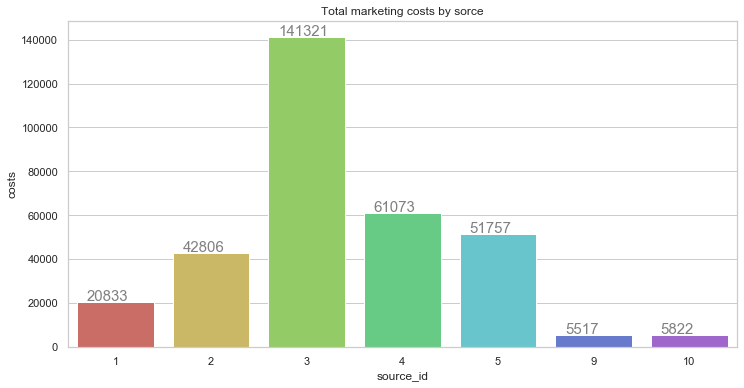

In [15]:
costs_by_source = costs.groupby('source_id').agg({'costs': 'sum'})
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=costs_by_source.index, y=costs_by_source.costs)
ax.set_title('Total marketing costs by sorce')
ax.set_ylabel('costs');
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+500, 
            str(int((i.get_height()))), fontsize=15, color='grey')
plt.show()

_А теперь построим график распределения затрат по месяцам, а также выведем общую сумму расходов на маркетинг:_

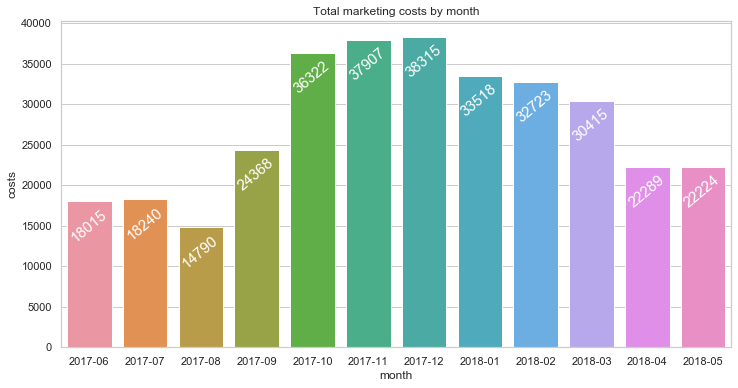

_______________

Total marketing costs: 329131.62


In [16]:
costs_by_month = costs.groupby('month').agg({'costs': 'sum'})
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=costs_by_month.index, y=costs_by_month.costs)
ax.set_title('Total marketing costs by month')
ax.set_ylabel('costs');
for i in ax.patches:
    ax.text(i.get_x()+.02, i.get_height()-5000, 
            str(int(i.get_height())), fontsize=15, color='white', rotation=40)
plt.show()
print('_______________')
print('')
print('Total marketing costs: {}'.format(costs['costs'].sum()))

##### Комментарий:

Из приведенных выше графиков расходов на рекламные компании мы видим, что больше всего трат уходит на рекламный ресурс под номером 3, а меньшего всего на ресурсы под номерами 1, 9 и 10. Также мы видим, что с октября по март расходы на рекламные компании были увеличены. Что, судя по предыдущим графикам по средним чекам и ATL дало свои плоды, и отразилось не столько на привлечении новых клиентов, сколько на покупках уже существующих.

<a name='cac_by_source'></a>
_Посчитаем CAC, чтобы узнать, сколько стоило привлечение одного покупателя из каждого источника:_
___
CAC (от англ. customer acquisition cost) — стоимость привлечения клиента.  
Сумма денег, во сколько обходится новый клиент компании.

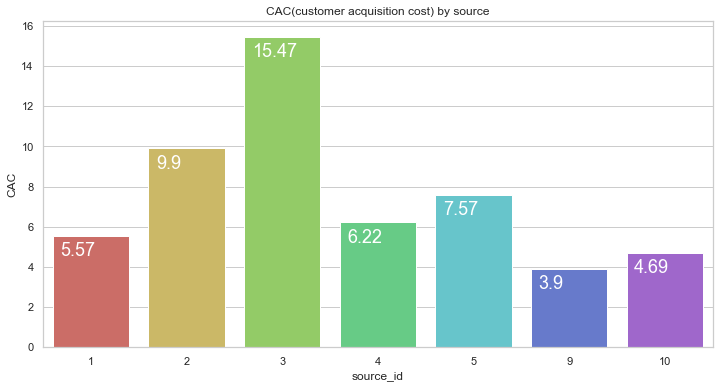

In [17]:
orders['first_buy_month'] = orders['first_buy_month'].dt.strftime('%Y-%m')
buyers_source = orders.loc[:,['uid','source_id', 'first_buy_month']]
n_users_by_source = (buyers_source
                     .reset_index()
                     .groupby('source_id')
                     .agg({'uid': 'nunique'})
                     .reset_index())
n_users_by_source.columns = ['source_id', 'n_users']
costs_by_source = costs_by_source.reset_index()
cac_by_source = costs_by_source.merge(n_users_by_source, on='source_id')
cac_by_source['cac'] = cac_by_source['costs'] / cac_by_source['n_users']

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=cac_by_source['source_id'], y=cac_by_source['cac'])
ax.set_title('CAC(customer acquisition cost) by source')
ax.set_ylabel('CAC');
for i in ax.patches:
    ax.text(i.get_x()+i.get_width()/10, i.get_height()-1, 
            str(round(i.get_height(), 2)), fontsize=18, color='white')
plt.show()


##### Комментарий:

Перед нами график стоимости привлечения пользователя, в зависимости от рекламного ресурса.
Дороже всего обходятся клиенты привлеченные рекламными ресурсами под номерами 2 и 3 (9,9 и 15,47 у.е. соответственно), а дешевле всего клиенты привлеченные рекламными ресурсами под номерами 9 и 10 (3,9 и 4,69 у.е. соответственно).

_А теперь посчитаем сколько стоило привлечение одного клиента в зависимости от когорты:_

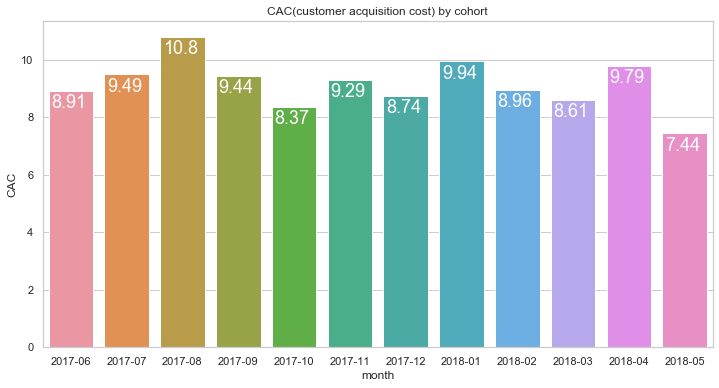

In [18]:
n_users_by_cohort = (buyers_source[buyers_source['first_buy_month'] <= '2018-05']
                     .reset_index()
                     .groupby('first_buy_month')
                     .agg({'uid': 'nunique'})
                     .reset_index())
n_users_by_cohort.columns = ['month', 'n_users']
costs_by_month = costs_by_month.reset_index()
cac_by_cohort = costs_by_month.merge(n_users_by_cohort, on='month')
cac_by_cohort['cac'] = round(cac_by_cohort['costs'] / cac_by_cohort['n_users'], 2)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=cac_by_cohort['month'], y=cac_by_cohort['cac'])
ax.set_title('CAC(customer acquisition cost) by cohort')
ax.set_ylabel('CAC');
for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()-.6, 
            str(round(i.get_height(), 2)), fontsize=18, color='white')
plt.show()

##### Комментарий:

Самые дорогие пользователи были в августовской когорте, но у них и самый высокий LTV.

<a name='romi'></a>
_Посчитаем ROMI, чтобы понять, на сколько окупились расходы на каждый рекламный ресурс:_  
___
ROMI (от англ. return on marketing investments) - возврат на маркетинговые инвестиции.

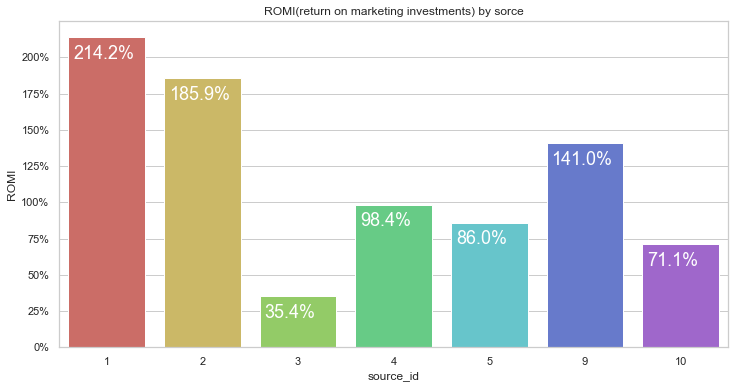

In [19]:
ltv_by_source = ltv_by_source.reset_index()
romi_by_source = (cac_by_source.loc[:,['source_id', 'cac']]
                  .merge(ltv_by_source.loc[:,['source_id', 'ltv']], on='source_id'))
romi_by_source['romi'] = romi_by_source['ltv'] / romi_by_source['cac']
romi_by_source 

plt.figure(figsize=(12, 6))
ax=sns.barplot(x=romi_by_source['source_id'], y=romi_by_source['romi'])
ax.set_title('ROMI(return on marketing investments) by sorce')
ax.set_ylabel('ROMI')
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(x) for x in vals])
for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()-.15, 
            str(round(i.get_height() *100, 1))+'%', fontsize=18, color='white')
plt.show()

##### Комментарий:

Итак, мы наконец получили показатели окупаемости инвестиций в маркетинг (ROMI) в зависимости от рекламного ресурса.  
На графике видно, что за жизненный цикл окупается только три рекламных ресурса: 
- 1-ый на 214%
- 2-ой на 186%
- 9-ый на 141%  
А остальные не окупаются:
- 4-ый на 98%
- 5-ый на 86%
- 10-ый на 71%
- 3-ий лишь на 35%  
Стоит сосредоточить инвестиции на успешных рекламных ресурсах, и менять концепцию в убыточных.

_Посмотрим как быстро окупались расходы на маркетинг в каждой из когорт:_

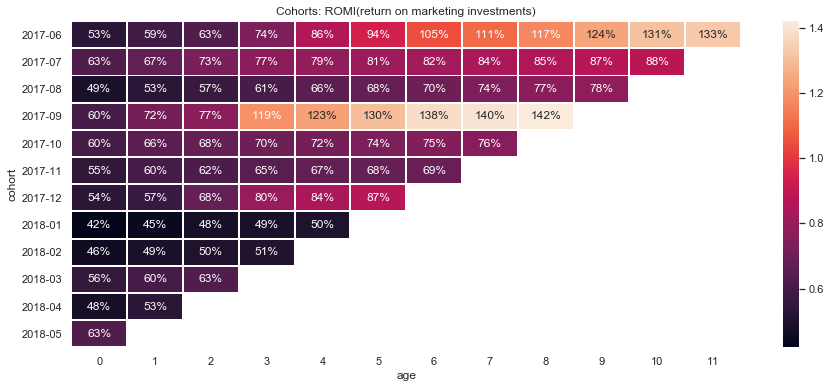

In [20]:
monthly_costs = costs.groupby('month').agg({'costs': 'sum'}).reset_index()
unit = orders.merge(monthly_costs, left_on='first_buy_month', right_on='month')

unit_cac = unit.groupby('month').agg({'costs': 'first', 'uid': 'nunique'}).reset_index()
unit_cac.columns = ['month', 'costs', 'n_buyers']
unit_cac['cac'] = unit_cac['costs'] / unit_cac['n_buyers']
unit = unit.merge(unit_cac.loc[:,['month', 'n_buyers','cac']], on='month')

unit_report = (unit
               .groupby(['month', 'age'])
               .agg({'revenue': 'sum', 'n_buyers': 'first', 'cac': 'first'})
               .reset_index())

unit_report.columns = ['cohort', 'age', 'revenue', 'n_buyers', 'cac']
unit_report['ltv'] = unit_report['revenue'] / unit_report['n_buyers']
unit_report['romi'] = unit_report['ltv'] / unit_report['cac']
output = unit_report.pivot_table(index='cohort',
                                 columns='age', 
                                 values='romi', 
                                 aggfunc='mean')
romi_pivot = output.cumsum(axis=1).round(2)
plt.figure(figsize=(15,6))
plt.title('Cohorts: ROMI(return on marketing investments)')
sns.heatmap(romi_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='white')
plt.show()

_Выведем средние показатели окупаемости маркетинговых расходов на протяжении "жизненного цикла"(6 полных месяцев+нулевой):_

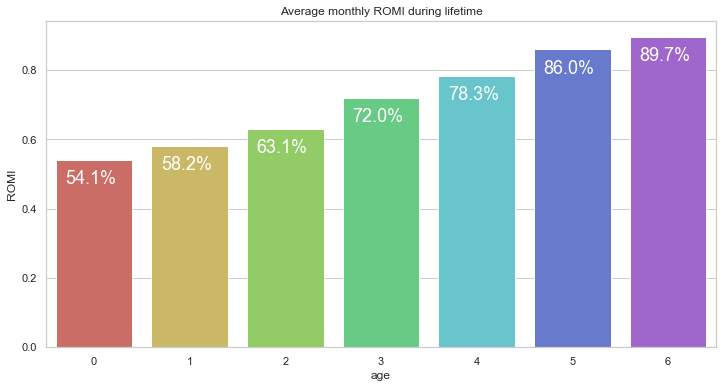

In [21]:
mean_monthly_romi = pd.DataFrame(output.cumsum(axis=1).mean(axis=0)[:7],columns=['romi'])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=mean_monthly_romi.index, y=mean_monthly_romi.romi)
ax.set_title('Average monthly ROMI during lifetime')
ax.set_ylabel('ROMI');
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()-0.07, 
            str(round(i.get_height() *100, 1))+'%', fontsize=18, color='white')
plt.show()

#### Вывод:

Из тепловой карты окупаемости инвестиций в маркетинг(ROMI) по когортам видно, что первая когорта окупилась на 6-ой месяц, а сентябрьская когорта окупилась даже на 3-й месяц, но к сожалению это исключения, остальные когорты не успели окупиться в рассматриваемый нами период.  
Отслеживая средний ROMI по месяцам, мы видим, что за жизненный цикл(6 месяцев) инвестиции в рекламу окупаются только на 89,7%.

Из тепловой карты окупаемости инвестиций в маркетинг(ROMI) по когортам видно, что первая когорта окупилась на 6-ой месяц, а сентябрьская когорта окупилась даже на 3-й месяц, но к сожалению это исключения, остальные когорты не успели окупиться в рассматриваемый нами период.  
Отслеживая средний ROMI по месяцам, мы видим, что за жизненный цикл(6 месяцев) инвестиции в рекламу окупаются только на 89,7%.

## Общий вывод

Средние показатели за весь период исследования:
- DAU _(количество уникальных пользователей в день)_ : 907 (из них пользователи ПК 72,3% / пользователи мобильных устройств 27,7%)
- DAU _(количество уникальных пользователей в день)_ : 5716 (из них пользователи ПК 71,6% / пользователи мобильных устройств 28,4%)
- MAU _(количество уникальных пользователей в месяц)_ : 23228 (из них пользователи ПК 71% / пользователи мобильных устройств 29%)  
Среднее количество сессий в день 987(из них 73% с десктопных и 27% с мобильных устройств), при этом обычно в день, один пользователь обращается к сервису только один раз.  
В исследовании есть [графики](#dau) по всем этим показателям.  

Чаще всего сессия длится 1 минуту, что может и достаточно для быстрой оценки основных показателей, но явно недостаточно для детального анализа и понимания принципов работы сервиса для потенциальных пользователей.
Возможно следует высвечивать банер для новых посетителей со ссылкой к описанию сервиса и краткими инструкциями _с чего начать?_  

Мы разделили всех приходящих пользователей на когорты, по месяцу прихода на сайт, чтобы посмотреть, как часто люди возвращаются.
На [тепловой карте](#retention) мы видим, что в первой когорте пользователи чаще возвращались на сайт. Также  в исследовании есть график, из которого видно, что в течении жизненного цикла _(для удобства расчётов будем считать "жизненный цикл" равным полных 6 мес. + нулевой)_ с каждым месяцем процент возвращающихся пользователей падает (с 6,5% в первый месяц до 3,7% в шестой).  
Такой маленький процент возврата возможно говорит о том, что потенциальные клиенты не всегда понимают суть предоставляемых услуг, а падение интереса со временем может говорить о не знании всех возможностей сервиса, что говорит в пользу создания простой и понятной памятки с возможностями приложения и инструкциями, а также страницы с ответом на часто задаваемые вопросы.

В среднем для тех, кто начал пользоваться сервисом с мобильного устройства, от первого визита до покупки проходит на 2 часа больше, чем для тех кто им пользовался с компьютера (4 часа против 6 часов 20 минут), к тому же с каждой новой когортой для пользователей ПК этот показатель в основном падает, чего нельзя сказать о пользователях мобильных устройств.  
Стоит поработать над мобильной версией, сделать её более удобной.  

Обычно пользователи делают не больше одной покупки, возможно стоит делать рассылку для старых пользователей со спецпредложением.  

Глядя на [тепловую карту](#aov) среднего чека мы видим, что в большинстве когорт средний чек со временем растёт. Также стоит отметить аномальные значения в третий месяц сентябрьской когорты(средний чек в этот месяц составил 138,7 у.е.), помимо этой когорты высокий средний чек был в первой когорте и в декабрьской. Необходимо запросить дополнительные данные по этим покупкам, что за пользователи их совершали какой порядок действий у них был, откуда пришли, возможно удастся повторить этот успех.  
Средний же чек среди всех покупок равен 5 у.е.  

А на [тепловой карте](#ltv) когорт, где средняя для когорты LTV(пожизненная ценность клиента) разбита по месяцам, видно, что наиболее продуктивный месяц сточки зрения LTV, первый.  

_Для удобства расчётов будем считать "жизненный цикл" равным 6 полных месяцев + нулевой_  
Средняя LTV(пожизненная ценность клиента) = 8,39 у.е.  

Так же перед нами [график](#ltv_source) величины LTV в зависимости от рекламного источника, по которому пришли пользователи. На нём видно, что лучшие показатели LTV у пользователей с источников под номером 1 и 2 (11,9 и 18,4 у.е. соответственно), а худшие у источников под номерами 3, 9, 10 (5,5, 5,5 и 3,3 у.е. соответственно).

Из приведенных выше [графиков](#costs_by_source) расходов на рекламные компании мы видим, что больше всего трат уходит на рекламный ресурс под номером 3, а меньшего всего на ресурсы под номерами 1, 9 и 10. Также мы видим, что с октября по март расходы на рекламные компании были увеличены. Что, судя по предыдущим графикам по средним чекам и ATL дало свои плоды, и отразилось не столько на привлечении новых клиентов, сколько на покупках уже существующих.  

[График](#cac_by_source) стоимости привлечения пользователя, в зависимости от рекламного ресурса, говорит нам о следующем: дороже всего обходятся клиенты привлеченные рекламными ресурсами под номерами 2 и 3 (9,9 и 15,47 у.е. соответственно), а дешевле всего клиенты привлеченные рекламными ресурсами под номерами 9 и 10 (3,9 и 4,69 у.е. соответственно).   

Анализируя вышеперечисленные метрики мы получили показатели окупаемости инвестиций в маркетинг (ROMI) в зависимости от рекламного ресурса.  
На [графике](#romi) видно, что за жизненный цикл окупается только три рекламных ресурса: 
- 1-ый на 214%
- 2-ой на 186%
- 9-ый на 141%  
А остальные не окупаются:
- 4-ый на 98%
- 5-ый на 86%
- 10-ый на 71%
- 3-ий лишь на 35%  
Стоит сосредоточить инвестиции на успешных рекламных ресурсах, и менять концепцию в убыточных.  

Из тепловой карты окупаемости инвестиций в маркетинг(ROMI) по когортам видно, что первая когорта окупилась на 6-ой месяц, а сентябрьская когорта окупилась даже на 3-й месяц, но к сожалению это исключения, остальные когорты не успели окупиться в рассматриваемый нами период.  
Отслеживая средний ROMI по месяцам, мы видим, что за жизненный цикл(6 месяцев) инвестиции в рекламу окупаются только на 89,7%.  


___
Проводя это исследование мы пришли к выводу, что __наиболее привлекательные ресурсы под номерами:__
- __1__ _(Самый большой показатель по ROMI - это значит что инвестиции быстрее всего себя окупят и можно будет вкладывать больше денег в развитие, а также очень хороший показатель LTV, и низкий CAC)_
- __2__ _(Самый большой показатель по LTV - это значит, что клиенты с этого рекламного ресурса будут приносить хорошие деньги на протяжении всего срока пользования продуктом, а также хороший показатель по ROMI)_
- __9__ _(Самый низкий показатель по CAC - а это значит что за меньшие деньги можно привлечь гораздо больше пользователей, а значит больше возможности получить дорогих сердцу покупателей, а также хороший показатель по ROMI)_